<a href="https://colab.research.google.com/github/pandian-raja/EVA4_Session11/blob/master/Session10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

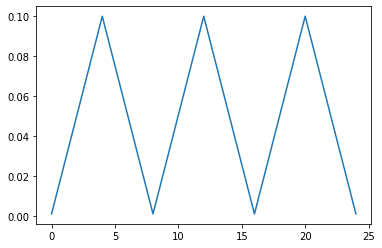

In [0]:
rate_array = []
def rate(iteration, stepsize, lr_min, lr_max):
    cycle = np.floor(1 + iteration/(2  * stepsize))
    x = np.abs(iteration/stepsize - 2 * cycle + 1)
    # lr = lr_min + (lr_max - lr_min) * np.maximum(0, (1-x))
    lr = lr_min + (lr_max - lr_min) * (1-x)
    return lr
lr = rate(20, 5, 0.001, 0.1)
for iteration in range(25):
    lr = rate(iteration, 4, 0.001, 0.1)
    rate_array.append(lr)

plt.plot(rate_array)

In [0]:
!pip install albumentations
!pip install torchsummary
from torchsummary import summary
import numpy as np
!pip install torch-lr-finder
from torch_lr_finder import LRFinder


In [31]:
!git clone https://github.com/pandian-raja/EVA4_Session11

fatal: destination path 'EVA4_Session11' already exists and is not an empty directory.


In [0]:
import os
os.rename("EVA4_Session11", "EVA4")


In [0]:
import EVA4.model.Session11 as rs
import EVA4.train_and_validate.train_and_validate as tv
import EVA4.DataLoader.GetData as gd


In [36]:
trainloader, testloader, classes, device = gd.GetData.importDataset()

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified



Learning rate search finished. See the graph with {finder_name}.plot()


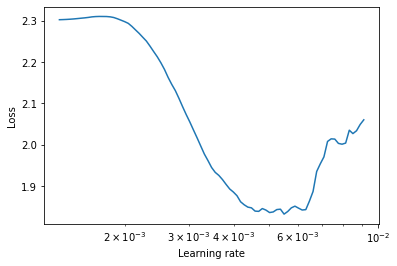

In [46]:
model = rs.Session11().to(device);
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay= 0.0001)
lr_finder = LRFinder(model, optimizer, criterion, device)
lr_finder.range_test(train_loader = trainloader, val_loader = testloader, start_lr = 0.001, end_lr=0.01, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph


In [47]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best LR = ",best_lr)

Best LR =  0.0054954087385762455


In [0]:
train_losses, train_acc, model,img,true_wrong,pred_wrong,test_acc,test_losses = tv6.train(model,device,trainloader,testloader,24,LEARNING_RATE = 0.001, MAX_LR=0.008)

Loss=1.500083327293396 Batch_id=97 Accuracy=35.61: 100%|██████████| 98/98 [00:14<00:00,  6.65it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.3781, Accuracy: 5018/10000 (50.18%)



Loss=1.0908637046813965 Batch_id=97 Accuracy=53.61: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1662, Accuracy: 5837/10000 (58.37%)



Loss=1.0783381462097168 Batch_id=97 Accuracy=60.13: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0275, Accuracy: 6417/10000 (64.17%)



Loss=1.0877280235290527 Batch_id=97 Accuracy=63.12: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4335, Accuracy: 5548/10000 (55.48%)



Loss=0.7385026216506958 Batch_id=97 Accuracy=67.15: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0973, Accuracy: 6478/10000 (64.78%)



Loss=0.8024657964706421 Batch_id=97 Accuracy=70.99: 100%|██████████| 98/98 [00:14<00:00,  6.58it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8266, Accuracy: 7221/10000 (72.21%)



Loss=0.7218901515007019 Batch_id=97 Accuracy=74.48: 100%|██████████| 98/98 [00:14<00:00,  6.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7003, Accuracy: 7541/10000 (75.41%)



Loss=0.7412980198860168 Batch_id=97 Accuracy=76.73: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5824, Accuracy: 7958/10000 (79.58%)



Loss=0.5976614356040955 Batch_id=97 Accuracy=78.66: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6329, Accuracy: 7867/10000 (78.67%)



Loss=0.46365103125572205 Batch_id=97 Accuracy=80.47: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5523, Accuracy: 8111/10000 (81.11%)



Loss=0.556986391544342 Batch_id=97 Accuracy=81.66: 100%|██████████| 98/98 [00:14<00:00,  6.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5451, Accuracy: 8075/10000 (80.75%)



Loss=0.5582292675971985 Batch_id=97 Accuracy=83.02: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5729, Accuracy: 8077/10000 (80.77%)



Loss=0.46878209710121155 Batch_id=97 Accuracy=84.05: 100%|██████████| 98/98 [00:14<00:00,  6.59it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5122, Accuracy: 8259/10000 (82.59%)



Loss=0.4595309793949127 Batch_id=97 Accuracy=84.76: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5353, Accuracy: 8190/10000 (81.90%)



Loss=0.3744792342185974 Batch_id=97 Accuracy=85.96: 100%|██████████| 98/98 [00:14<00:00,  6.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4660, Accuracy: 8431/10000 (84.31%)



Loss=0.3581699728965759 Batch_id=97 Accuracy=86.59: 100%|██████████| 98/98 [00:14<00:00,  6.54it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4724, Accuracy: 8433/10000 (84.33%)



Loss=0.3348392844200134 Batch_id=97 Accuracy=87.17: 100%|██████████| 98/98 [00:14<00:00,  6.58it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4453, Accuracy: 8487/10000 (84.87%)



Loss=0.42685654759407043 Batch_id=97 Accuracy=88.02: 100%|██████████| 98/98 [00:14<00:00,  6.58it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4259, Accuracy: 8572/10000 (85.72%)



Loss=0.36601176857948303 Batch_id=97 Accuracy=88.71: 100%|██████████| 98/98 [00:14<00:00,  6.58it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4033, Accuracy: 8630/10000 (86.30%)



Loss=0.31550338864326477 Batch_id=97 Accuracy=89.23: 100%|██████████| 98/98 [00:14<00:00,  6.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3994, Accuracy: 8665/10000 (86.65%)



Loss=0.22869938611984253 Batch_id=97 Accuracy=90.03: 100%|██████████| 98/98 [00:14<00:00,  6.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3848, Accuracy: 8708/10000 (87.08%)



Loss=0.3327380120754242 Batch_id=97 Accuracy=90.32: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3800, Accuracy: 8726/10000 (87.26%)



Loss=0.232192724943161 Batch_id=97 Accuracy=90.63: 100%|██████████| 98/98 [00:14<00:00,  6.59it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3763, Accuracy: 8731/10000 (87.31%)



Loss=0.28625577688217163 Batch_id=97 Accuracy=90.90: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s]



Test set: Average loss: 0.3749, Accuracy: 8732/10000 (87.32%)

